## Goal

We want better estimate of $\bar{C}_{ij} = p(w_2 = j | w_1 = i) = \frac{C_{ij}}{p(w_1 = i)}$, the  probability of seeing $j$ conditional on word $i$. We can get good estimate of $p(w_1 = i)$, so we need to improve $C_{ij} = p(w_1 = i, w_2 = j)$, the co-occurrence probability for word pair $(i, j)$. 


## Empirical Estimate

Given document $d$, whith $(n^d, n^d_i, n^d_j)$ being (# of total word counts, # of word $i$, # of word $j$). The empirical estimate is:

\begin{align}
    \hat{C}^d_{ij} &= \frac{n^d_i n^d_j}{n^d (n^d - 1)} \approx \hat{\pi}^d_i \hat{\pi}^d_j\\
    \hat{\pi}^d_i & = \frac{n^d_i}{n^d}
\end{align}

Then $\hat{C}_{ij} = \frac{1}{D}\sum_d \hat{C}^d_{ij}$ is averaging estimates over all $D$ documents.

### Issues

The estimate is poor for many in-frequent words. Since in the next step we treat each row of $\bar{C}$ as a point in high-dimension and find extramal point among the rows, the poor estimate of those entries in $\bar{C}$ cause severe problems.


## A Simpler Model

In Empirical estimate we can see estimating of $\pi^d_i$ is key. We mainly want to shrink those in-frequent words so that their $\bar{C}$ rows don't stand out. Below I disregard the weak dependency among multinomial counts and treat each as generated from binomial: 

\begin{align}
    & n^d_i \sim \text{Bin}(n^d, \pi^d_i)\\
    & \pi^d_i \sim \text{Beta}(a_i, b_i)
\end{align}

We use EB to estimate $a_i, b_i$, borrowing information from $n^d_i$ across all documents. This is of course over-simplifying, but we hope: shrinkage effect on anchor words are small, as there is lots of variation; shrinkage effect on background words are strong, as their frequency don't vary much.  (We can think of this as a test whether a word changes frequency across documents). Then hopefully we can see most words have almost constant $\pi_i^d$; as a result in after transforming to rows of $\bar{C}$ they should be almost the same. 



In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from scipy.stats import betabinom
from scipy.optimize import minimize

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 


In [2]:
## n = (n_1, ..., n_D) is total word counts in D documents
## x = (x_1, ..., x_D) is counts for one word in D documents
## return pi_pos
def betabinom_shrinkage(n, x, ab = np.array([1,1])):
    ab = mle_bb(n, x, ab)
    mu, var =  beta_mean_var(ab[0], ab[1])
    
    return pos_beta(n, x, ab), ab, mu, var

def obj_bb(ab_root, n, x):
    ab = ab_root**2
    return -betabinom.logpmf(x, n, ab[0], ab[1], loc=0).sum()

def mle_bb(n, x, ab):
    res = minimize(obj_bb, np.sqrt(ab), args=(n, x), method='BFGS')
    
    return res.x**2

def pos_beta(n, x, ab):
    
    return (ab[0] + x) / (ab.sum() + n)

def beta_mean_var(a, b):
    mu = a / (a + b)
    var = a*b/((a + b + 1) * (a+b)**2)
    
    return mu, var


# n = np.random.poisson(50, 200)
# a = b = 0.5
# x = betabinom.rvs(n, a, b)

# ab = np.array([0.5, 0.5])
# res = mle_bb(n, x, ab)
# print(res)
# pi_pos, ab, mu, var = betabinom_shrinkage(n, x)
# plt.hist(pi_pos)
# plt.show()

## simulate data

In [ ]:
# n = 1000
# p = 1200 ## make this larger to increase difficulty
# n_top = 20 ## number of top words in each topic
# k = 3
# doc_len = 80
# np.random.seed(123)

# X, Atrue, Ftrue, p0, Ltrue = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len, 
#                                            n_top = n_top, returnL=True)
# w_idx = np.where(X.sum(axis = 0) > 0)[0]
# X = X[:,w_idx]

# Pi_true = Ltrue @ Ftrue.T

# Pi = np.empty([X.shape[0], X.shape[1]])
# AB = np.empty([4, X.shape[1]])
# N = X.sum(axis = 1)
# for i in range(X.shape[1]):
#     Pi[:, i], ab, mu, var = betabinom_shrinkage(N, X[:, i])
#     AB[:, i] = ab[0], ab[1], mu, var

# out = {"X":X, "Atrue":Atrue, "Ftrue":Ftrue, "Ltrue":Ltrue, 
#        "Pi_true":Pi_true, "Pi":Pi, "AB":AB}
# file = open('improve_C.pkl', 'wb')
# pickle.dump(out, file)
# file.close()

In [5]:
file = open('improve_C.pkl', 'rb')
out = pickle.load(file)
file.close()


X = out["X"]
Ftrue = out["Ftrue"]
Ltrue = out["Ltrue"]
Pi_true = out["Pi_true"]
Pi = out["Pi"]
AB = out["AB"]
k = 3 ## forgot to store

In [6]:
%%capture
Clong, _, _ = X2C(sparse.coo_matrix(X))
Slong_fit, Blong_fit, Along_fit, _, _, _, _, Clong = factorizeC(Clong, K=k, rectifier='AP', optimizer='activeSet')

In [7]:
Slong_fit

array([393, 487, 537])

[ 0.57205921 64.1200803 ]
[0.008842793250576545, 0.00013341928459614097]


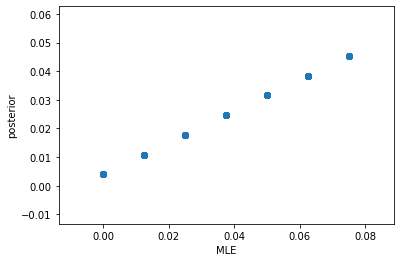

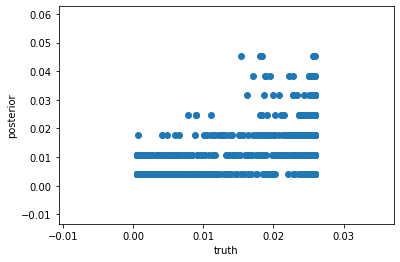

In [8]:
N = X.sum(axis = 1)

idx = 12
pi , ab, mu, var = Pi[:, idx], AB[:2, idx], AB[2, idx], AB[3, idx]

print(ab)
print([mu, var])

plt.scatter(X[:, idx]/N, pi)
plt.ylabel("posterior")
plt.xlabel("MLE")
plt.show()

plt.scatter(Pi_true[:, idx], pi)
plt.ylabel("posterior")
plt.xlabel("truth")
plt.show()

In [9]:
X[:, 537].sum() ## much smaller than average

7.0

[1.90921986e-01 1.51921353e+03]
[0.0001256558020264915, 8.263591451028092e-08]


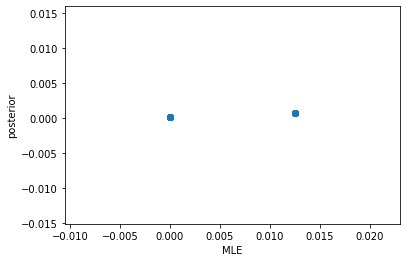

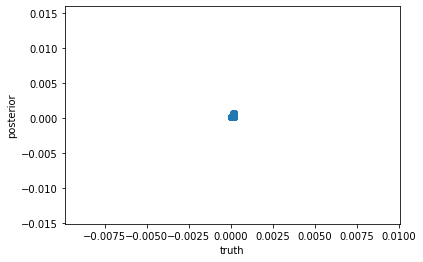

In [24]:
idx = 537
pi , ab, mu, var = Pi[:, idx], AB[:2, idx], AB[2, idx], AB[3, idx]

print(ab)
print([mu, var])

plt.scatter(X[:, idx]/N, pi)
plt.ylabel("posterior")
plt.xlabel("MLE")
plt.show()

plt.scatter(Pi_true[:, idx], pi)
plt.ylabel("posterior")
plt.xlabel("truth")
plt.show()

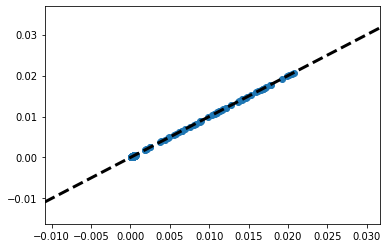

In [64]:
weights_word = X.sum(axis = 0) / X.sum()
weights_word_est = Pi.mean(axis = 0)
plt.scatter(weights_word, weights_word_est)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

## Directly recoverS from $\Pi$

In [16]:
Pi_true_scaled = Pi_true / Pi_true.sum(axis = 0)[None,:]

In [17]:
# %%capture
Strue_fit, _,  _ = findS(Pi_true.T, 3) ## even forgot to scale right... still answer is correct
print(Strue_fit)

Strue_fit, _,  _ = findS(Pi_true_scaled.T, 3) ## even forgot to scale right... still answer is correct
print(Strue_fit)

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0095 seconds

[30 41  2]
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0097 seconds

[26  5 49]


In [18]:
Pi_scaled = Pi / Pi.sum(axis = 0)[None, :]

In [19]:
S, _,  _ = findS(Pi_scaled.T, 3)
print(S)

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0172 seconds

[487 429 393]


### Find outliers

In [36]:
Pi_scaled_pc = Cbar_proj(Pi_scaled.T)

Pi_scaled_pc[:, 0].max()
idx = np.argmax(Pi_scaled_pc[:, 0])
print(Pi_scaled_pc[idx, 0])
print((Pi_scaled_pc[:, 0] > 0.005).sum())
print(X[:, idx].sum()) ## very very rare word that should be removed
print(AB[:, idx])

0.21291940904995627
1
1.0
[3.68951117e-03 3.37910992e+02 1.09184696e-05 3.22156311e-08]


In [49]:
Pi2 = np.delete(Pi, idx, axis=1)
Pi2_scaled = Pi2 / Pi2.sum(axis = 0)[None, :]

S2, _,  _ = findS(Pi2_scaled.T, 3)
print(S2)

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0124 seconds

[429 393 558]


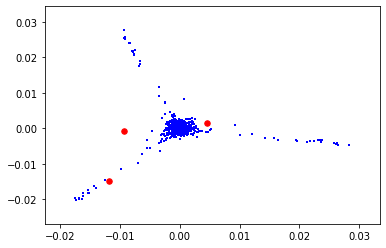

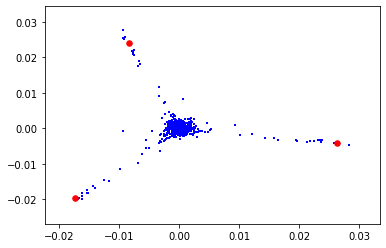

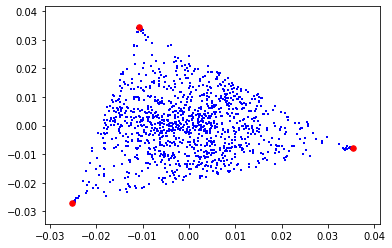

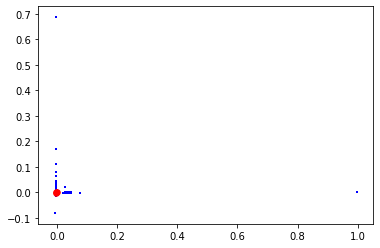

In [55]:
which_dim = [0,1]
vis_extremal_pca(Cbar_proj(Pi2_scaled.T), S2, which_dim)
vis_extremal_pca(Cbar_proj(Pi2_scaled.T), Strue_fit, which_dim)
vis_extremal_pca(Cbar_proj(Pi_true_scaled.T), Strue_fit, which_dim)


Pi_naive = X / X.sum(axis = 1)[:, None]
vis_extremal_pca(Cbar_proj(Pi_naive.T), Strue_fit, which_dim)





* Still more outliers to remove

* Pi's structure is no longer the right convex hull... Naive Pi also won't work... some very baad extremal points

## Form C and recoverS

In [82]:
n, p = Pi.shape
Chat = (Pi.T @ Pi)/n
Chat_bar = Chat / Chat.sum(axis = 1)[:, None]

## construct C from Pi true
## ad hoc when filling in diagonal elements
Chat0 = (Pi_true.T @ Pi_true)/n
Chat0_bar = Chat0 / Chat0.sum(axis = 1)[:, None]

S0, _,  _ = findS(Chat0_bar, 3)
print(S0)

S, _,  _ = findS(Chat_bar, 3)
print(S)



[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0189 seconds

[49 26  5]
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0123 seconds

[41 30  2]


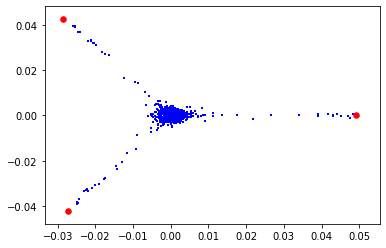

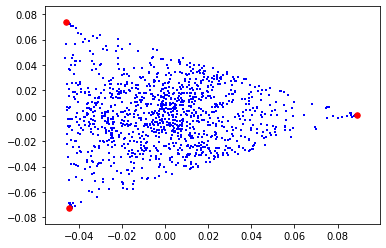

In [84]:
which_dim = [0,1]
vis_extremal_pca(Cbar_proj(Chat), S, which_dim)

vis_extremal_pca(Cbar_proj(Chat0), S, which_dim)

It finds the right anchor words!! But caution here the geometry is quite different (shrunk too hard; like a variable selection step)... the advantage of directly working on $\Pi$ is that outliers are gone